In [1]:
# Imports
import glob
import pandas as pd
import numpy as np
import uproot
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Define transformation onto latent space
def smoothing_function(u: np.ndarray, alpha: float=4, beta: float=3, gamma: float=1) -> np.ndarray:
    
    x1 = (1 / (1 + np.exp(alpha * (u - beta) - gamma)))
    
    x2 = (1 / (1 + np.exp(-alpha * (u + beta) - gamma)))
    
    # q = (1 / (1 + np.exp(alpha * (u - beta) - gamma))) * (1 / (1 + np.exp(-alpha * (u + beta) - gamma)))
    
    return x1 * x2

def get_cumalative_distribution(data: np.ndarray, weights: np.ndarray=None, npoints: int=50, lower_lim: float=None, upper_lim: float=None) -> np.ndarray:
    
    if lower_lim is None:
        lower_lim = np.amin(data)
    if upper_lim is None:
        upper_lim = np.amax(data)
    if weights is None:
        weights = np.ones_like(data, weights, npoints, lower_lim, upper_lim)
    
    ax_scan_points = np.linspace(lower_lim, upper_lim, npoints + 1)
    
    data_cdf = []
    for point in ax_scan_points :
        data_cdf.append(np.sum([w for x,w in zip(data, weights) if x < point]))
        
    data_cdf = np.array(data_cdf) / sum(weights)
    
    return data_cdf

def transform_onto_latent_space(data: np.ndarray, conf: OmegaConf, weights: np.ndarray=None):
    
    weights = weights / np.sum(weights)
    xmin = np.amin(data)
    xmax = np.amax(data)
    x_scan_points = np.linspace(xmin, xmax, 1 + conf.n_axis_points)

    umin = conf.smooth_space_limits[0]
    umax = conf.smooth_space_limits[1]
    udiv = conf.smooth_space_division
    
    data_cdf = get_cumalative_distribution(data, npoints=conf.n_axis_points, weights=weights)
    constant_cdf = (x_scan_points - xmin) / (xmax - xmin)
    combined_cdf = conf.data_frac_constant * constant_cdf + (1 - conf.data_frac_constant) * data_cdf
    
    latent_space_x = np.linspace(umin, umax, 1 + int(2 * umax / udiv))
    smooth_space_y = smoothing_function(latent_space_x, conf.alpha, conf.beta, conf.gamma)
    
    smooth_space_cdf = np.array([np.sum(smooth_space_y[:i+1]) for i in range(len(smooth_space_y))])
    smooth_space_cdf /= smooth_space_cdf[-1]
    smooth_space_cdf[0] = 0.
    
    constant_cdf    = (latent_space_x + umax) / (2 * umax)
    
    latent_space_cdf = conf.gauss_frac_constant * constant_cdf + (1 - conf.gauss_frac_constant) * smooth_space_cdf

    A_to_z = lambda A : np.interp(A, x_scan_points, combined_cdf)     # x -> x_CDF
    z_to_A = lambda z : np.interp(z, combined_cdf  , x_scan_points)   # x_CDF -> x

    z_to_g = lambda z : np.interp(z, latent_space_cdf, latent_space_x  )  # u_CDF -> u
    g_to_z = lambda g : np.interp(g, latent_space_x  , latent_space_cdf)  # u -> u_CDF

    A_to_g = lambda A : z_to_g(A_to_z(A))  # x -> u
    g_to_A = lambda g : z_to_A(g_to_z(g))  # u -> x
    
    return A_to_g, g_to_A
    

[-4.         -3.72413793 -3.44827586 -3.17241379 -2.89655172 -2.62068966
 -2.34482759 -2.06896552 -1.79310345 -1.51724138 -1.24137931 -0.96551724
 -0.68965517 -0.4137931  -0.13793103  0.13793103  0.4137931   0.68965517
  0.96551724  1.24137931  1.51724138  1.79310345  2.06896552  2.34482759
  2.62068966  2.89655172  3.17241379  3.44827586  3.72413793  4.        ]
[0.04742587 0.13049925 0.31150269 0.57696943 0.80436353 0.9253417
 0.97393344 0.99119977 0.99706347 0.99902396 0.999676   0.99989245
 0.99996419 0.99998774 0.99999477 0.99999477 0.99998774 0.99996419
 0.99989245 0.999676   0.99902396 0.99706347 0.99119977 0.97393344
 0.9253417  0.80436353 0.57696943 0.31150269 0.13049925 0.04742587]


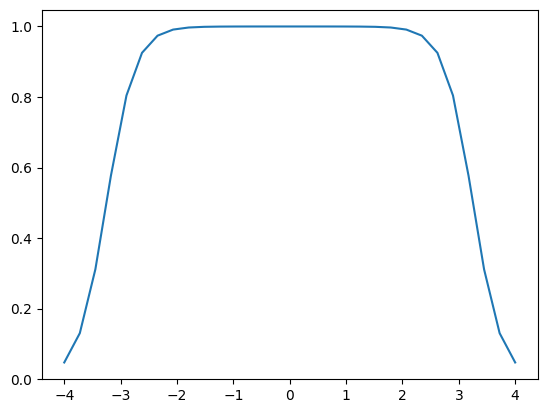

In [3]:
fig, ax = plt.subplots()
u  = np.linspace(-4, 4, 30)
print(u)
print(smoothing_function(u))
ax.plot(u, smoothing_function(u))

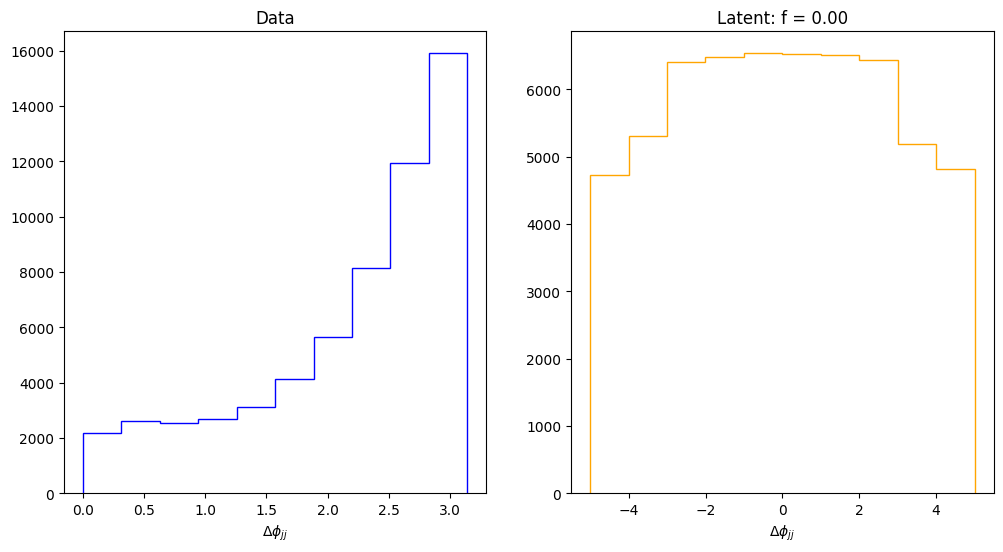

In [4]:
# Plot delta_phi_jj
# Load data

global_conf = OmegaConf.load('config/config.yaml')
dphi_jj_conf = OmegaConf.load('config/features/delta_phi_jj.yaml')
conf = OmegaConf.merge(global_conf, dphi_jj_conf)
dataset = uproot.concatenate('data/lrsm.root', library='pd')
# dataset = pd.read_csv("/home/bewilson/gaussian_mixture_models/data/csvs/mumu-mc.MGPy8EG_lrsm132_mumuchannel_WRWL_4.50_0.55_0.020_0.000_.EVNT.csv")

# for csv in glob.glob("data/csvs/*.csv"):

for gfc in np.linspace(0, 1, 11):
    
    # print(csv)

    # dataset = pd.read_csv(csv)
    
    delta_phi_jj = dataset['delta_phi_jj']
    weights = dataset['weight']
    
    conf['data_frac_constant'] = float(gfc)
    

    x_to_latent_space, latent_space_to_x = transform_onto_latent_space(delta_phi_jj, conf, weights=weights)

    delta_phi_jj_trans = x_to_latent_space(delta_phi_jj)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6));
    ax1.hist(dataset['delta_phi_jj'], 10, histtype='step', density=False, color='blue');
    ax2.hist(delta_phi_jj_trans, 10, histtype='step', density=False, color='orange');
    ax1.set_xlabel(r"$\Delta\phi_{jj}$");
    ax2.set_xlabel(r"$\Delta\phi_{jj}$");
    ax1.set_title("Data")
    ax2.set_title(f"Latent: f = {gfc:.2f}")
    
    break

Index(['weight', 'eTmiss', 'lep1_pT', 'lep2_pT', 'dilep_pT', 'jet1_pT',
       'jet2_pT', 'dijet_pT', 'HT', 'mjj', 'mll', 'mlljj', 'ml1jj', 'ml2jj',
       'delta_rap_jj', 'delta_rap_ll', 'rap1', 'rap2', 'delta_phi_jj',
       'delta_phi_ll', 'delta_R_jj', 'delta_R_ll', 'delta_R_lljj', 'njets',
       'external_params[0]'],
      dtype='object')
Observable delta_rap_jj closure is 1.00000 +- 0.00000     (should be 1 +- 0)


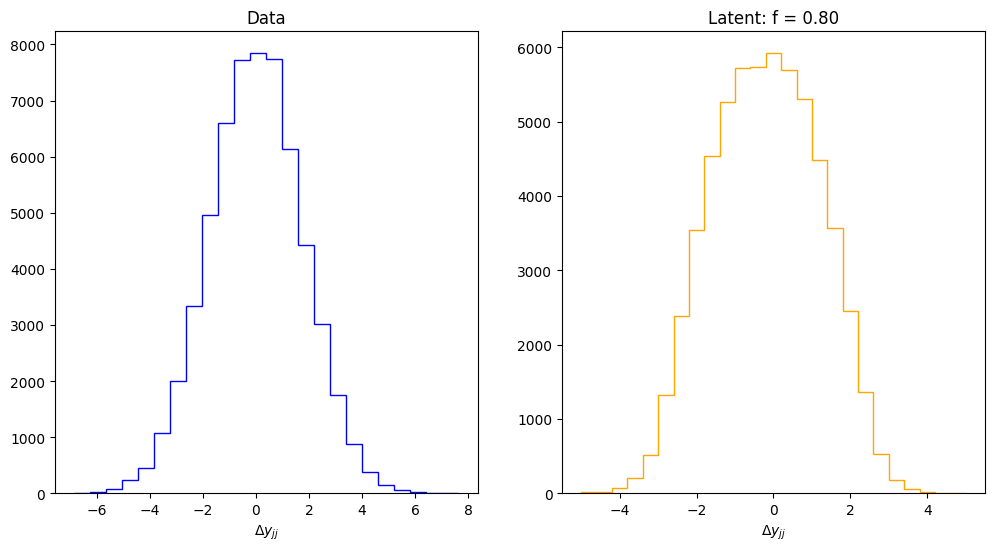

In [5]:
global_conf = OmegaConf.load('config/config.yaml')
dataset = uproot.concatenate('data/lrsm.root', library='pd')
weights = dataset['weight']

print(dataset.keys())

for feature in global_conf.features:
    obs_conf = OmegaConf.load(f'config/features/{feature}.yaml')    
    conf = OmegaConf.merge(global_conf, obs_conf)

    obs_data = dataset[feature]
    
    x_to_latent_space, latent_space_to_x = transform_onto_latent_space(obs_data, conf, weights=weights)

    obs_transformed = x_to_latent_space(obs_data)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6));
    ax1.hist(obs_data, 24, histtype='step', density=False, color='blue');
    ax2.hist(obs_transformed, 25, histtype='step', density=False, color='orange');
    ax1.set_xlabel(conf.latex_name);
    ax2.set_xlabel(conf.latex_name);
    ax1.set_title("Data")
    ax2.set_title(f"Latent: f = {conf.data_frac_constant:.2f}")
    
    # Check closure
    obs_trans_back = latent_space_to_x(obs_transformed)

    ratio = (obs_trans_back / obs_data).transpose()
    print(f"Observable {feature} closure is {np.mean(ratio):.5f} +- {np.std(ratio):.5f}     (should be 1 +- 0)")
    

In [6]:
# Create GMM 
import tensorflow as tf
from   keras.activations import softplus
from   keras.layers      import BatchNormalization, Dense, Dropout, Input, LeakyReLU, Concatenate, Lambda, Reshape, Softmax
from   keras.models      import Model
from   keras.optimizers  import Adam, SGD, Adadelta
from   keras.callbacks   import Callback, EarlyStopping
import keras.backend     as     K

def custom_weight_init_initial (shape, dtype=None, g=0.2) :
    """Keras: custom weight initialiser function for leaky relu layer with gradient g (first layer in network)"""
    limit = 4. / np.sqrt(shape[0]) / (1 + g)
    return K.random_uniform(shape, -limit, limit, dtype=dtype)

def custom_weight_init_hidden (shape, dtype=None, g=0.2) :
    """Keras: custom weight initialiser function for leaky relu layer with gradient g (not first layer in network)"""
    limit = 3. / np.sqrt(shape[0]) / (1 + g)
    return K.random_uniform(shape, -limit, limit, dtype=dtype)

def add_gauss_mean_offsets (x, num_gauss, offset_min, offset_max) :
    """TF method: for input x of size [?, num_gauss], add evenly spaced offsets between [offset_min, offset_max]"""
    c = tf.convert_to_tensor([offset_min + (offset_max-offset_min)*i/(num_gauss-1.) for i in range(num_gauss)])
    return x + c    

def set_initial_gauss_sigmas (x, num_gauss, offset_min, offset_max, gauss_width_factor) :
    """TF method: for input x of size [?, num_gauss], add a constant factor which sets initial Gaussian widths as gauss_width_factor * (offset_max-offset_min) / num_gauss
       - to be applied before a Softmax function, so offset addition is performed in a logarithmic basis"""
    target_width = gauss_width_factor * float(offset_max - offset_min) / num_gauss
    offset       = float(np.log(np.exp(target_width) - 1))
    c = tf.convert_to_tensor([offset for i in range(num_gauss)])
    return x + c

def add_epsilon_to_gauss_sigmas (x, num_gauss, epsilon=1e-4) :
    """TF method: for input x of size [?, num_gauss], add epsilon to every value"""
    c = tf.convert_to_tensor([float(epsilon) for i in range(num_gauss)])
    return x + c

def add_gauss_fraction_offsets (x, num_gauss, const_frac=0.2) :
    """TF method: for input x of size [?, num_gauss], where x is a multinomial(num_gauss) probability distribution, add a constant term to prevent probabilities going to 0"""
    c = tf.convert_to_tensor([1./num_gauss for i in range(num_gauss)])
    return (1.-const_frac)*x + const_frac*c

def K_gauss_prob (x, mean, sigma) :
    """return the Gaussian probability density for datapoints x"""
    prob = K.exp(-0.5*(x - mean)*(x - mean)/(sigma*sigma)) / K.sqrt(2*np.pi*sigma*sigma)
    return prob

def K_datapoint_likelihood (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    """Keras: return the probability density for datapoints x as described by the Gaussian mixture model"""
    prob = 0.
    x = x[:,0]
    for i in range(num_gauss) :
        prob = prob + gauss_fracs[:,i] * K_gauss_prob(x, gauss_means[:,i], gauss_sigmas[:,i])
    return prob

def K_datapoint_log_likelihood (x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas) :
    """Keras: return the log probability density for datapoints x as described by the Gaussian mixture model"""
    return K.log(K_datapoint_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas))

def K_dataset_log_likelihood (x, params, num_gauss) :
    """Keras: return the log probability density for datapoints x as described by the Gaussian mixture model"""
    gauss_fracs, gauss_means, gauss_sigmas = params[:,:num_gauss], params[:,num_gauss:2*num_gauss], params[:,2*num_gauss:3*num_gauss]
    return K_datapoint_log_likelihood(x, num_gauss, gauss_fracs, gauss_means, gauss_sigmas)

def GMM(conf: OmegaConf) -> tf.keras.Model:
    
    N1     = conf.A1 + conf.A2 * conf.n_external_parameters
    N2     = conf.B1 + conf.B2 * conf.n_observables if conf.n_observables > 0 else 0
    
    conditions_input  = Input((conf.n_external_parameters,))
    model_conditions  = conditions_input
    model_conditions  = Dense(N1, kernel_initializer=custom_weight_init_initial, bias_initializer='zeros', activation='relu')(model_conditions) 
    if conf.use_leaky_relu : model_conditions = LeakyReLU (0.2)      (model_conditions)
    if conf.batch_norm     : model_conditions = BatchNormalization() (model_conditions)
    if conf.dropout > 0.   : model_conditions = Dropout(conf.dropout)     (model_conditions)
    
    #
    #  If they exist, create an input layer for other input observables
    #  -  if configured, add a layer which transforms these inputs onto the given domain
    #  -  add a layer to process just these inputs
    #  -  concatenate the resulting hidden layer with that from the external parameter dependence
    #  If they don't exist, skip this step
    #
    
    if conf.n_observables > 0 :
        observables_input = Input((conf.n_observables,))
        model_observables = observables_input
        model_observables = Dense(N2, kernel_initializer=custom_weight_init_initial, bias_initializer='zeros', activation='relu')(model_observables)    
        if conf.use_leaky_relu : model_observables = LeakyReLU(0.2)       (model_observables)
        if conf.batch_norm     : model_observables = BatchNormalization() (model_observables)
        if conf.dropout > 0.   : model_observables = Dropout(conf.dropout)     (model_observables)
        model             = Concatenate()([model_conditions, model_observables])
    else :
        model = model_conditions
        
    for c in range(conf.C) :
        model = Dense (N1 + N2, kernel_initializer=custom_weight_init_hidden, bias_initializer='zeros', activation='relu')(model)
        if conf.use_leaky_relu : model = LeakyReLU (0.2)      (model)
        if conf.batch_norm     : model = BatchNormalization() (model)
        if conf.dropout > 0.   : model = Dropout(conf.dropout)     (model)
    
    gauss_means     = Dense (conf.D2 * conf.num_gaussians, kernel_initializer=custom_weight_init_hidden, bias_initializer='zeros', activation='relu')(model)
    if conf.use_leaky_relu : gauss_means = LeakyReLU (0.2)      (gauss_means)
    if conf.batch_norm     : gauss_means = BatchNormalization() (gauss_means)
    if conf.dropout > 0.   : gauss_means = Dropout(conf.dropout)     (gauss_means)
    gauss_means = Dense (conf.num_gaussians, kernel_initializer=custom_weight_init_hidden, bias_initializer='zeros', activation="linear")(gauss_means)
    gauss_means = Lambda(lambda x : conf.gauss_mean_scale * x)(gauss_means)
    gauss_means = Lambda(lambda x : add_gauss_mean_offsets(x, conf.num_gaussians, conf.range_min, conf.range_max))(gauss_means)
    
    gauss_sigmas       = Dense (conf.D2 * conf.num_gaussians   , kernel_initializer=custom_weight_init_hidden, bias_initializer='zeros', activation='relu')(model)
    if conf.use_leaky_relu : gauss_sigmas = LeakyReLU (0.2)      (gauss_sigmas)
    if conf.batch_norm     : gauss_sigmas = BatchNormalization() (gauss_sigmas)
    if conf.dropout > 0.   : gauss_sigmas = Dropout(conf.dropout)     (gauss_sigmas)
    gauss_sigmas = Dense (conf.num_gaussians     , kernel_initializer=custom_weight_init_hidden, bias_initializer='zeros', activation='relu')(gauss_sigmas)
    gauss_sigmas = Lambda (lambda x : conf.gauss_sigma_scale * x )                                                                (gauss_sigmas)
    gauss_sigmas = Lambda (lambda x : set_initial_gauss_sigmas(x, conf.num_gaussians, conf.range_min, conf.range_max, conf.gauss_width_factor))(gauss_sigmas)
    gauss_sigmas = Lambda (lambda x : K.log(1. + K.exp(x)))                                                                (gauss_sigmas)
    gauss_sigmas = Lambda (lambda x : add_epsilon_to_gauss_sigmas(x, conf.num_gaussians))                                       (gauss_sigmas)
    
    
    gauss_fractions = Dense(conf.D2 * conf.num_gaussians , kernel_initializer=custom_weight_init_hidden, bias_initializer='zeros', activation='relu')(model)
    if conf.use_leaky_relu : gauss_fractions = LeakyReLU (0.2)      (gauss_fractions)
    if conf.batch_norm     : gauss_fractions = BatchNormalization() (gauss_fractions)
    if conf.dropout > 0.   : gauss_fractions = Dropout(conf.dropout)     (gauss_fractions)
    gauss_fractions = Dense(conf.num_gaussians, kernel_initializer=custom_weight_init_hidden, bias_initializer='zeros', activation="linear")(gauss_fractions)
    gauss_fractions = Lambda(lambda x : conf.gauss_frac_scale * x)                                                    (gauss_fractions)
    gauss_fractions = Softmax()                                                                                (gauss_fractions)
    gauss_fractions = Lambda(lambda x : add_gauss_fraction_offsets(x, conf.num_gaussians, conf.min_gauss_amplitude_frac))(gauss_fractions)
    
    
    model = Concatenate()([gauss_fractions, gauss_means, gauss_sigmas])
    if conf.n_observables > 0 : model = Model ([conditions_input, observables_input], model, name='GMM')
    else                      : model = Model (conditions_input, model, name='GMM')
    
    loss_function = lambda y_true, y_pred : -1. * K_dataset_log_likelihood(y_true, y_pred, conf.num_gaussians)
    
    if   conf.optimiser.lower() == "sgd"      : model.compile(loss=loss_function, optimizer=SGD     (learning_rate=conf.learning_rate), weighted_metrics=[])    
    elif conf.optimiser.lower() == "adadelta" : model.compile(loss=loss_function, optimizer=Adadelta(learning_rate=conf.learning_rate), weighted_metrics=[])    
    elif conf.optimiser.lower() == "adam"     : model.compile(loss=loss_function, optimizer=Adam    (learning_rate=conf.learning_rate), weighted_metrics=[])   
    else : raise ValueError(f"Optimiser '{conf.optimiser}' not recognised") 
    
    return model, (conf.n_external_parameters, conf.n_observables, conf.num_gaussians)

2022-10-04 16:33:47.434181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-04 16:33:47.677025: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-04 16:33:48.366930: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bewilson/scratch/rivet/local/lib:/home/bewilson/scratch/rivet/local/lib64:/home/bewilson/scratch/rivet/local/lib64:/home/bewilson/scratch/rivet/local/lib64:/home/bewilson/scratch/rivet/local/lib64:/home/be

In [68]:
# Train model
from gc import callbacks
from sklearn.model_selection import train_test_split


def train_model(model_conf, dataset, obs):
    
    # model_conf = OmegaConf.load('../config/features/delta_phi_jj.yaml')

    model, params = GMM(model_conf)
    weights = dataset['weight']
    
    x_to_latent_space, latent_space_to_x = transform_onto_latent_space(dataset[obs], model_conf, weights=weights)

    y = x_to_latent_space(dataset[obs])

    x = dataset[model_conf.external_params]

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    
    history = model.fit(x, y, sample_weight=weights, validation_split=0.1, epochs=100, batch_size=model_conf.batch_size, shuffle=True, callbacks=[early_stopping]);

    return model, history

def plot_history(history, obs):
    # Plot loss vs epochs
    fig, ax = plt.subplots();
    ax.plot(history.history['loss'], label='Train');
    ax.plot(history.history['val_loss'], label='Val');
    ax.set_xlabel("Epochs");
    ax.set_ylabel("Loss");
    ax.set_title(obs)
    ax.legend();
    
def histo_to_line (bins, values, errors=None) :
    X, Z, EZ = [], [], []
    for i in range(len(bins)-1) :
        X .append(bins[i])
        X .append(bins[i+1])
    for zp in values :
        Z .append(zp)
        Z .append(zp)
    if type(errors) is type(None) :
        return np.array(X), np.array(Z)
    for ezp in errors :
        EZ.append(ezp)
        EZ.append(ezp)
    return np.array(X), np.array(Z), np.array(EZ)

# Evaluate model
import scipy
from matplotlib import cm

def plot_gmm(model, model_conf, obs, latex_name):

    weights = dataset['weight']
    x_to_latent_space, latent_space_to_x = transform_onto_latent_space(dataset[obs], model_conf, weights=weights)
    y = x_to_latent_space(dataset[obs])

    x = dataset[model_conf.external_params]
    
    params = model.predict(x[:1]);
    num_gauss = model_conf.num_gaussians;

    gauss_fracs, gauss_means, gauss_sigmas = params[:,:num_gauss], params[:,num_gauss:2*num_gauss], params[:,2*num_gauss:3*num_gauss];

    x_range = np.linspace(-5, 5, 501);
    sum_gauss = 0

    newcolors = cm.get_cmap('brg', num_gauss)(np.linspace(0, 1, num_gauss));

    fig, (ax1, ax2) = plt.subplots(nrows=2);
    for i, (frac, mean, sigma) in enumerate(zip(gauss_fracs[0], gauss_means[0], gauss_sigmas[0])):
        gauss_y = frac * scipy.stats.norm.pdf(x_range, mean, sigma);
        sum_gauss += gauss_y
        ax1.plot(x_range, gauss_y, c=newcolors[i], linewidth=0.6, linestyle="-");
        
    ax1.plot(x_range, sum_gauss, color='black', label=r"$p_\phi(u|{M_{N}, M_{W_{R}}})$")
    ax1.hist(y, bins=100, density=True, histtype='step', label='MG5');
    ax1.set_xlabel(r"{0} Latent".format(latex_name));
    ax1.legend();
    
    gauss_hist, bins = np.histogram(x_range, bins=np.linspace(-5, 5, 25), density=True, weights=sum_gauss)
    nom_hist, bins = np.histogram(y, bins=np.linspace(-5, 5, 25), density=True)
    
    residual = gauss_hist / nom_hist;
    
    ax2.plot(bins, np.ones_like(bins), color='black')
    ax2.stairs(residual, bins, color='red', baseline=1)
    plt.tight_layout()
    plt.savefig(f"{obs}.png", dpi=300)
    
    
    

Training delta_phi_jj
Epoch 1/100
52/52 [==============================] - 13s 79ms/step - loss: 0.0070 - val_loss: 0.0081
Epoch 2/100
52/52 [==============================] - 2s 46ms/step - loss: 0.0067 - val_loss: 0.0080
Epoch 3/100
52/52 [==============================] - 2s 45ms/step - loss: 0.0066 - val_loss: 0.0073
Epoch 4/100
52/52 [==============================] - 2s 46ms/step - loss: 0.0066 - val_loss: 0.0068
Epoch 5/100
52/52 [==============================] - 2s 46ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 6/100
52/52 [==============================] - 2s 47ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 7/100
52/52 [==============================] - 2s 46ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 8/100
52/52 [==============================] - 2s 42ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 9/100
52/52 [==============================] - 2s 42ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 10/100
52/52 [==============================] - 2s 42ms/step - loss: 0.

/tmp/ipykernel_12077/1012329940.py:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(nrows=2);


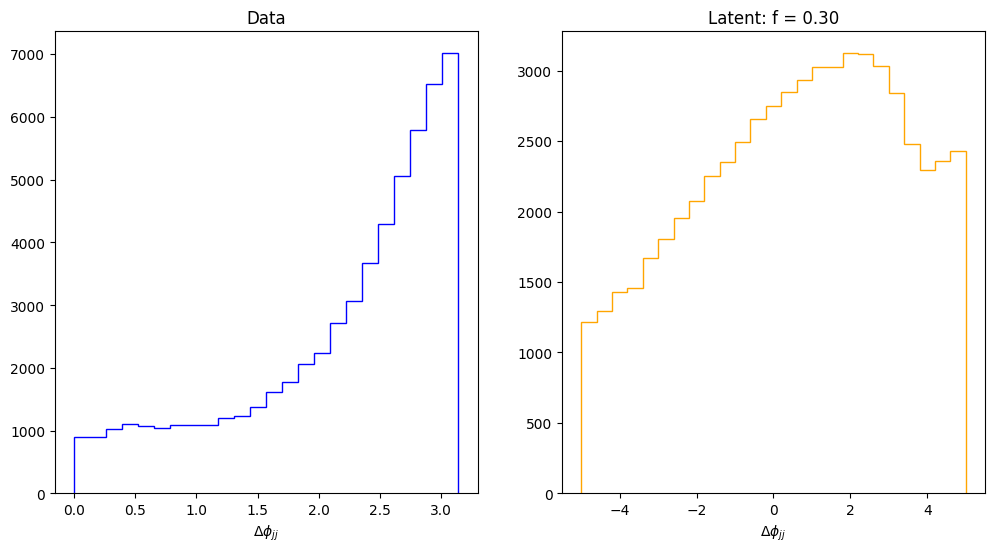

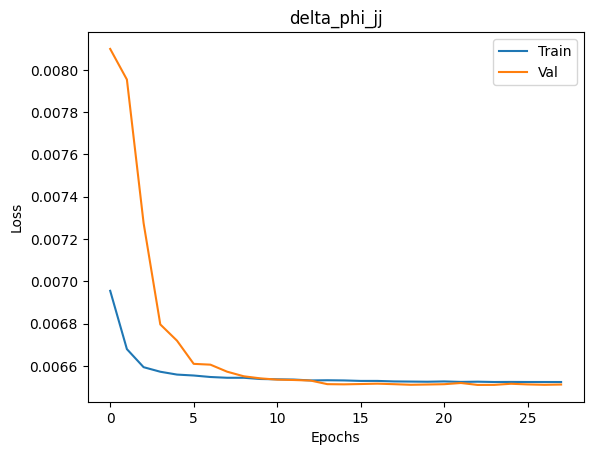

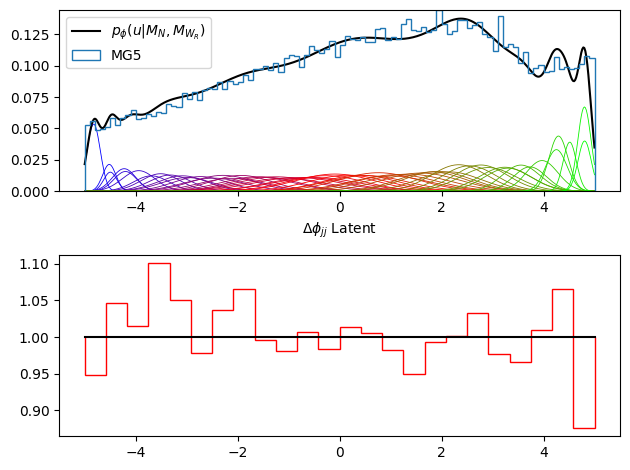

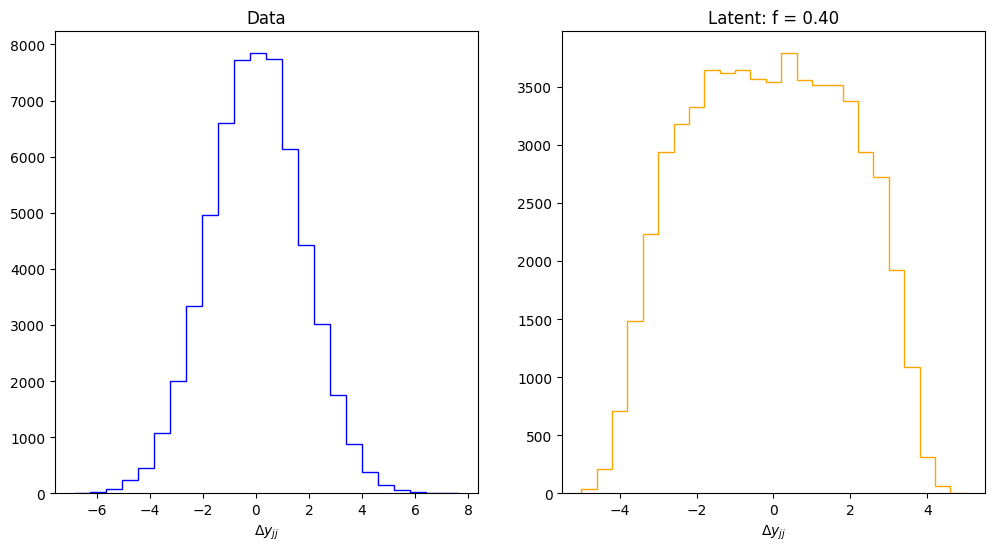

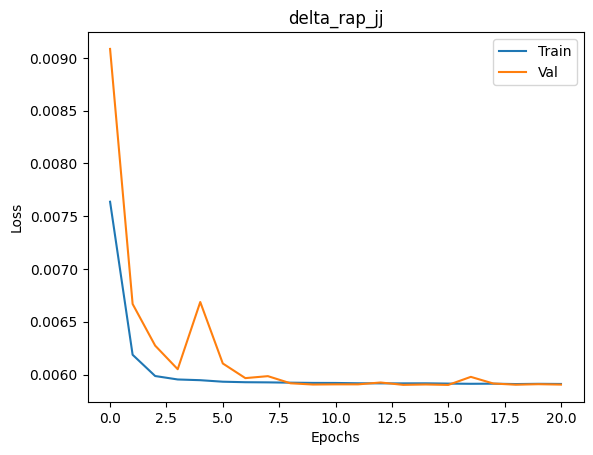

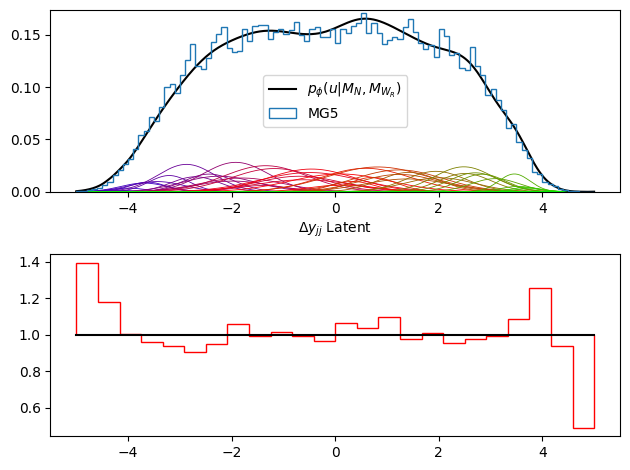

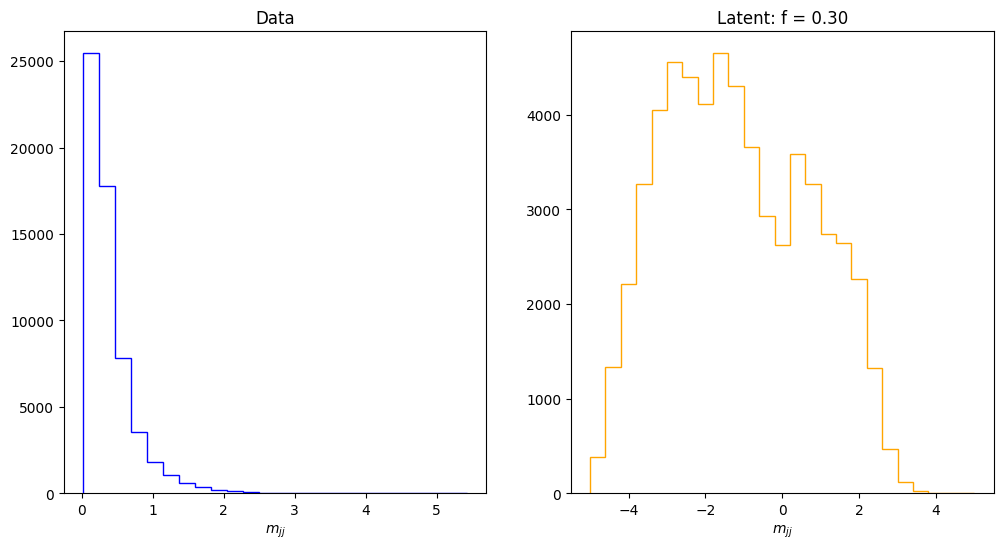

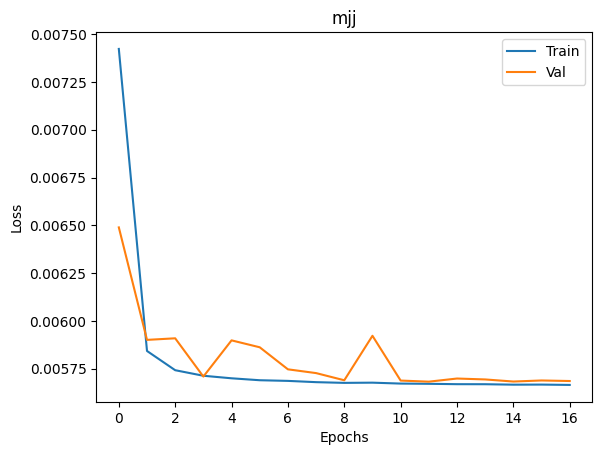

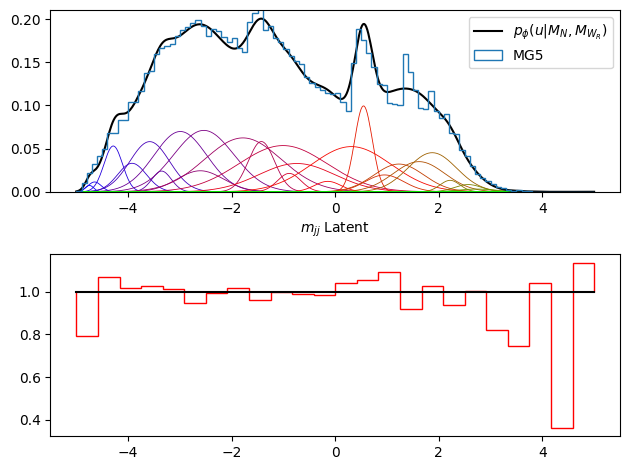

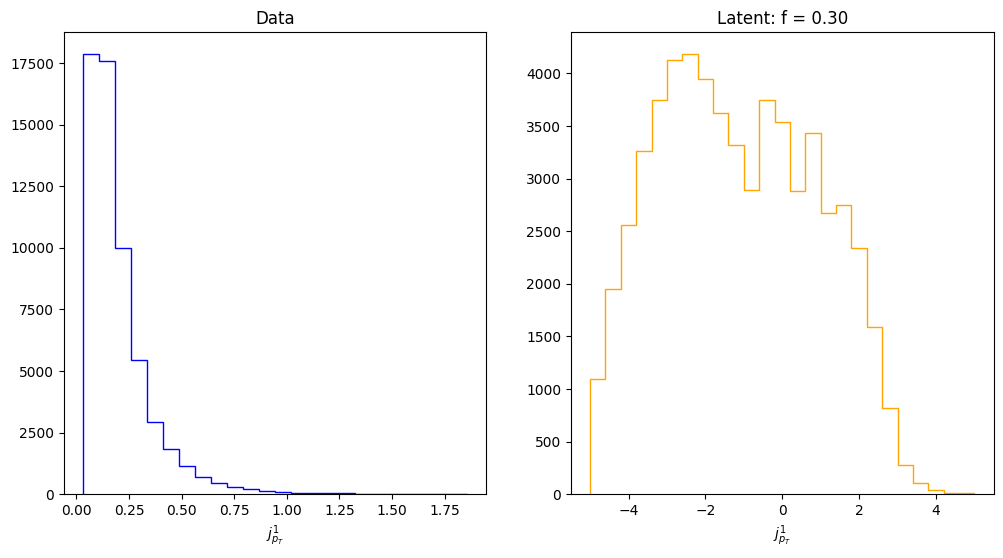

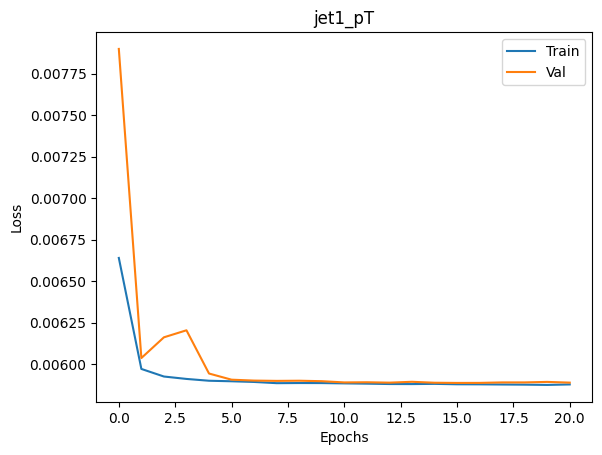

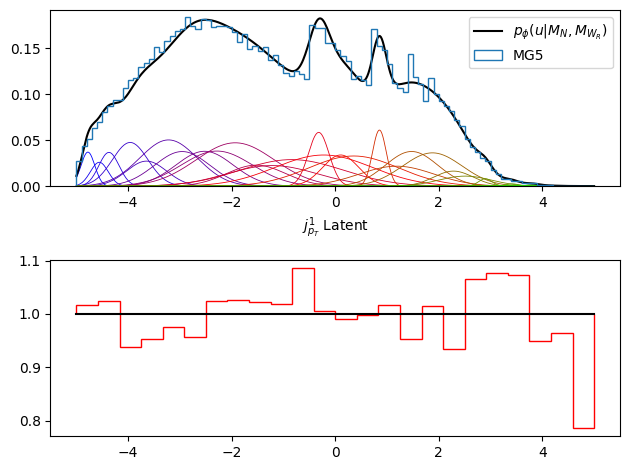

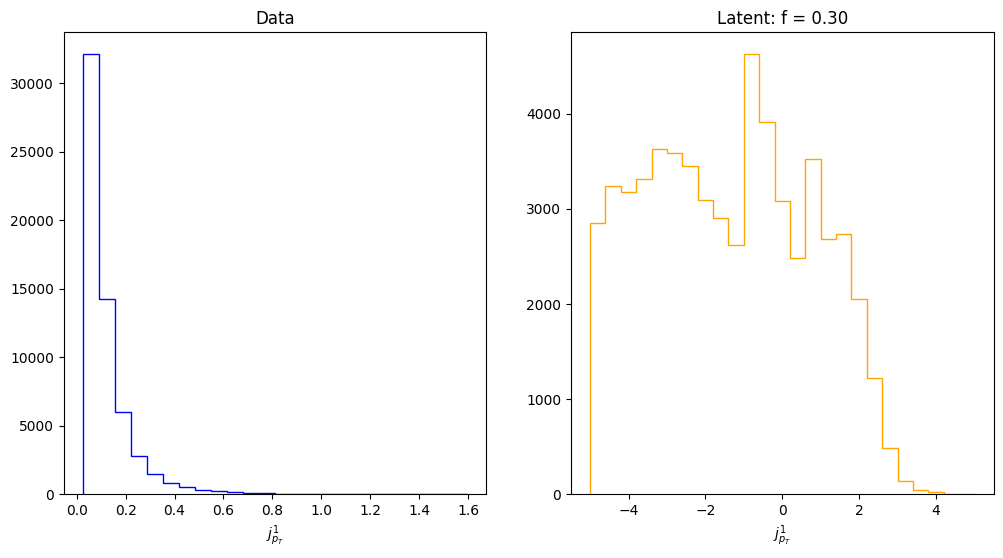

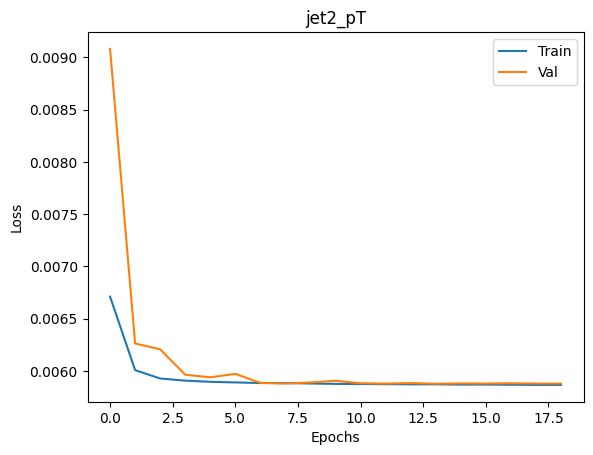

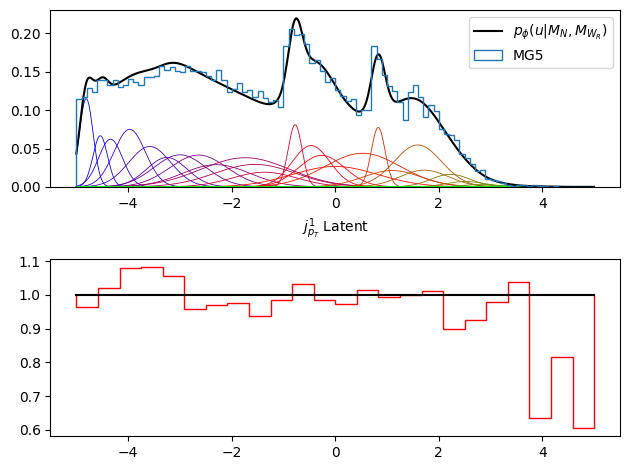

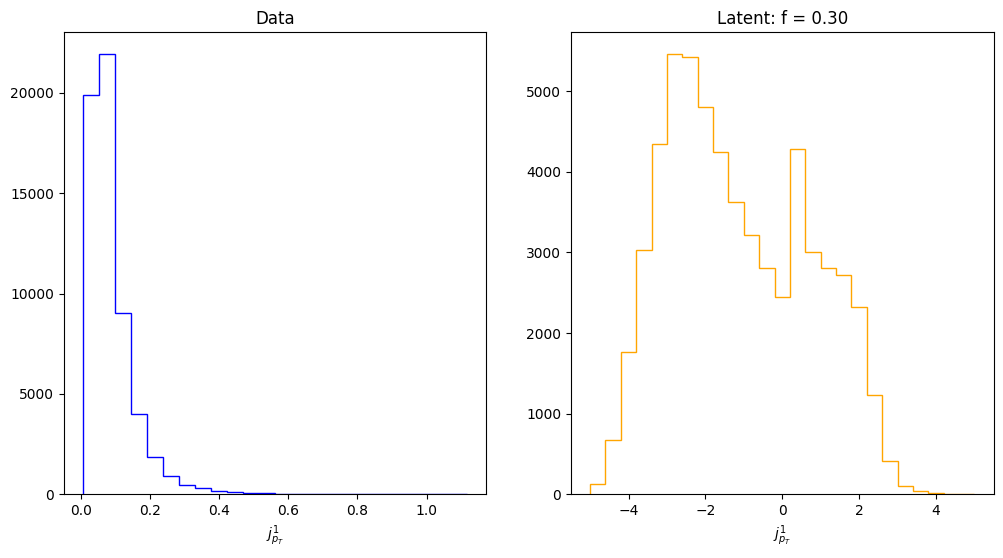

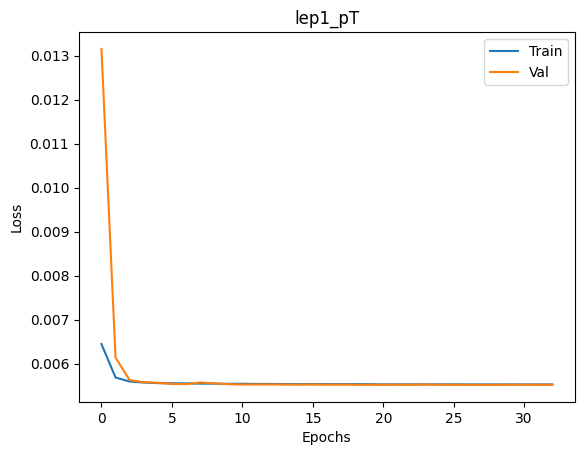

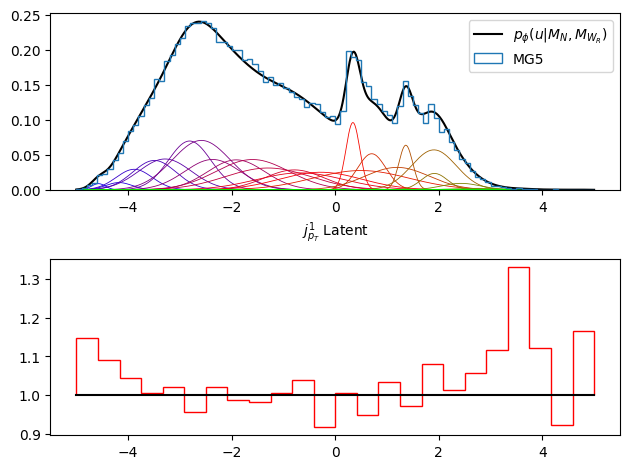

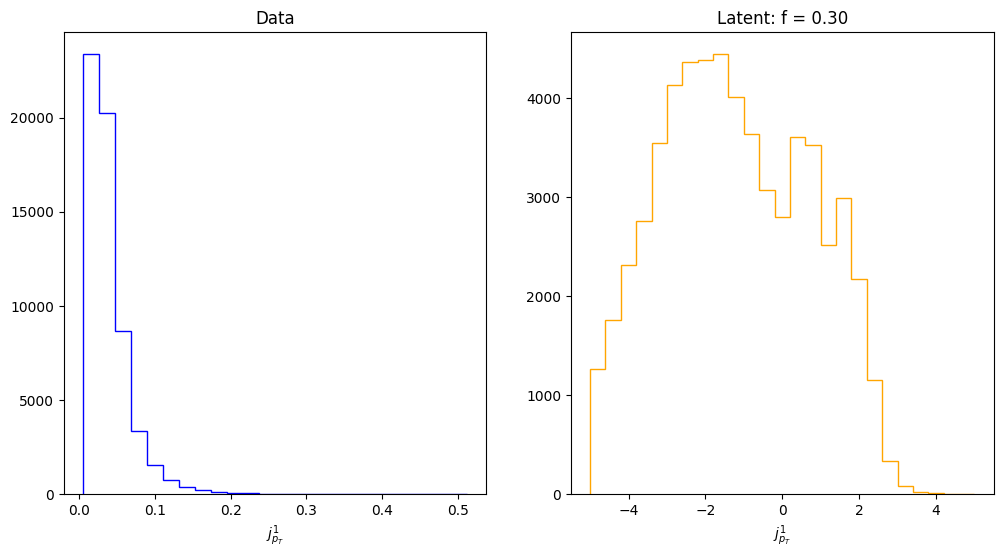

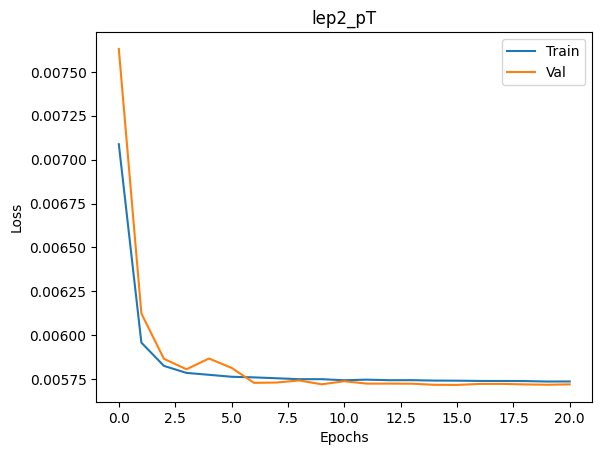

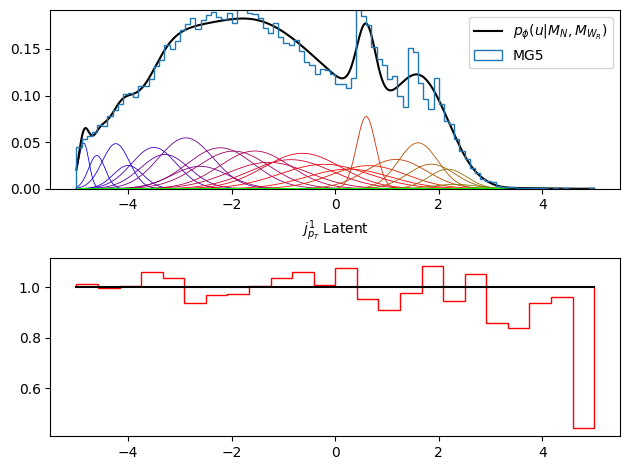

In [70]:
results = {}

global_conf = OmegaConf.load('config/config.yaml')
for feature in global_conf.features:
    obs_conf = OmegaConf.load(f'config/features/{feature}.yaml')    
    conf = OmegaConf.merge(global_conf, obs_conf)
    
    print(f"Training {feature}")
    weights = dataset['weight']
    obs_data = dataset[feature]
    x_to_latent_space, latent_space_to_x = transform_onto_latent_space(obs_data, conf, weights=weights)
    obs_transformed = x_to_latent_space(obs_data)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6));
    ax1.hist(obs_data, 24, histtype='step', density=False, color='blue');
    ax2.hist(obs_transformed, 25, histtype='step', density=False, color='orange');
    ax1.set_xlabel(conf.latex_name);
    ax2.set_xlabel(conf.latex_name);
    ax1.set_title("Data")
    ax2.set_title(f"Latent: f = {conf.data_frac_constant:.2f}")
    
    model, history = train_model(conf, dataset, feature)
    
    # conf.batch_size = 5000
    
    plot_history(history, feature)
    plot_gmm(model, conf, feature, conf.latex_name)
    
    results[feature] = [model, history]

In [67]:
for obs, (model, _) in results.items():
    
    obs_conf = OmegaConf.load(f'config/features/{feature}.yaml')    
    conf = OmegaConf.merge(global_conf, obs_conf, conf.latex_name)
    
    plot_gmm(model, conf, obs)
    